# Sentiment analysis for the IMDB reviews dataset

In this notebook, we tackle IMDB reviews sentiment analysis (download link available on the [README file](./README.md)). It consists of 50000 reviews, each associated a positive or negative sentiment. The goal of this notebook is to build a classifier that is available to predict the sentiment given the reviews, with high accuracy.

In a first stage, we select a subset of data to work on (e.g 5000 samples, i.e. 10% of the whole dataset). The goal of this step is to experiment with different cleaning strategies, and to perform hyperparameter selection. 

Then, we will divide the whole dataset into 25000 train samples, and 25000 test samples.
    * The train sample is used to train a model with hyperparamters obtained from the cross-validaton procedure on the data subset used previously.
    * The test set is used solely for model performance assessment. 

## Libraries imports

Depending on whether the nltk resources needed for data cleaning are present on the machine or not, this notebook cell might take some time to execute depending on the internet speed connection, to download the nltk lacking resources.

In [1]:
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn import linear_model, ensemble, naive_bayes

import pandas as pd
import numpy as np
import joblib
from itertools import chain


import utils, postprocess as postproc, preprocess as preproc, tuning
from os import path
from functools import partial
from tqdm.auto import tqdm
tqdm.pandas()
import pprint


[nltk_data] Downloading package wordnet to /home/sdhouib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sdhouib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sdhouib/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/home/sdhouib/sklearn-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Using a data subset
We select a subset of data points, we use half of them for training and the other half for testing.

In [2]:
if not path.exists("./data/data_raw_sub.csv"):
    df_raw_all = pd.read_csv("./data/data_raw.csv")
    df_raw_sub = model_selection.train_test_split(df_raw_all, train_size= 0.02, 
                                                  stratify = df_raw_all["sentiment"],
                                                  random_state= 0)[0]
    df_raw_sub.to_csv("data/data_raw_sub.csv", index= False)

df_raw_sub = pd.read_csv("data/data_raw_sub.csv")
df_raw = pd.read_csv("data/data_raw.csv")
df_raw_sub.head()

,review,sentiment
0,"Well, okay, maybe not perfect, but it was pret...",positive
1,"Even though it has one of the standard ""Reveng...",positive
2,The brilliance of this story delivers at least...,positive
3,A really funny British comedy from the mid 195...,positive
4,Director J.S. Cardone presents something a lit...,negative


# Data reading and cleaning
In this part, we perform data cleaning. This is done one time over the whole data sets, and comprises processing steps that do not affect the task at hand (sentiment analysis in this case. ) In other words, these steps are not tunable. Such steps necessarily do not depend on the data distribution, but solely on the example at hand. They include:
* Removing html tags
* Removing punctuation
* Shortening/Removing long spaces and other characters (i.e. underscores)

Once the cleaning is done (or if the cleaned file already exists), then a subset of training set is selected, on which most of the experiments to select a model are carried out.

In [10]:
df_cln_sub = df_raw_sub.copy()
df_cln = df_raw.copy()

df_cln = df_raw.copy()
text_processor = partial(preproc.clean_text, check_spell= False, normalize= None, rm_stop_words= False,
steps = preproc.clean_steps_before_normalize[0:5])
df_cln_sub["review"] = df_raw_sub["review"].progress_apply(text_processor)
df_cln["review"] = df_raw["review"].progress_apply(text_processor)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:09<00:00, 5196.90it/s]


In [20]:
preproc.clean_steps_before_normalize[0:1][0]("<646?>")

' '

In [5]:
words = []
for s in tqdm(df_cln["review"]):
    words.extend(s.split())
unk_words = preproc.spell.unknown(words)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [11]:
unk_words

{'dyin',
 'reshot',
 'paulson',
 'mrs',
 'uub',
 'nr',
 'cadwell',
 'hrgd',
 'nivoli',
 'rollin',
 'kimbell',
 'vladislav',
 'wylie',
 'sharkey',
 'mohawks',
 'mindness',
 'eine',
 'partes',
 'geralt',
 'clonation',
 'wymark',
 'trainwrecks',
 'kramden',
 'zis',
 'shenar',
 'vil',
 'asssociated',
 'amjad',
 'bromley',
 'dlr',
 'canaan',
 'dispensationalism',
 'blehhh',
 'catman',
 'dearable',
 'mumy',
 'doga',
 'rgb',
 'singin',
 'wearin',
 'henstridge',
 'sondheim',
 'boeing',
 'corpo',
 'cassella',
 'bhasra',
 'spock',
 'alt',
 'evre',
 'jafar',
 'trvor',
 'dmitri',
 'tastic',
 'fantsastic',
 'despited',
 'norfolk',
 'veddy',
 'accussed',
 'jose',
 'afictionado',
 'historicaly',
 'hitlers',
 'sadfully',
 'balanchine',
 'extendedly',
 'naffness',
 'shikhar',
 'shovelware',
 'langlois',
 'rivio',
 'courteney',
 'anulka',
 'woking',
 'krupa',
 'belmonndo',
 'uktv',
 'minghellian',
 'meeks',
 'naissance',
 'pacierkowski',
 'worlde',
 'bashung',
 'hoohum',
 'jlu',
 'vinterbergs',
 'bigga'

In [4]:
joined_corpus = " ".join(df_raw["review"].values).lower()
for w in tqdm(unk_words):
    unk_in_corpus = w in joined_corpus
    if not unk_in_corpus:
        print("problem with word: '%s'"%w)



NameError: name 'unk_words' is not defined

In [12]:
inds = np.where(df_cln["review"].apply(lambda x: "dyin" in x.lower()))[0]
pprint.pp(df_raw["review"].values[inds])

array(["No one can say I wasn't warned as I have read the reviews (both user & external), but like most of us attracted to horror movies... curiosity got this cat. (Come on, we all scream at the people in the movie not to go into the dark room, but you know that's horror aficionados are always dying to know what's in there even if we know it'll be bad).<br /><br />The bottom line is that this movie left me angry. Not because it pretends to be real (who cares...gimmicks are allowed), or because the actors and dialogue are so lame (is this an unusual event in horror movies?) or even because the movie is so bad (and I am being polite here). What really got me mad is that the film is not only a rip off of BWP, but also a half-hearted lazy rip off at that.<br /><br />I don't believe in sacred cows and if they thought they could outdo BWP then kudos to them, but they didn't even try. The movie was made with little effort or care and that is the most unforgivable sin in horror (or any) movie!

## Building and training a model
We build a model that is a succession of:
* One or many preprocessing steps, coded via the Scikit-Learn transformers. We use `TfidfVectorizer` which is equivalent to a `CountVectorizer` followed by `TfidfTransformer`.
* A classifier. By default, we choose a linear classifier optimized via the stochastic gradient descent algorithm.
  


In [ ]:
model = Pipeline([
    # ("preproc", preprocessor),
    ("tfidf", text.TfidfVectorizer(use_idf=True, ngram_range=(1, 1),
                                   min_df=0.0, max_df=1.0,
                                   stop_words=utils.sw_nltk)),
    ("clf", linear_model.SGDClassifier(alpha=1e-4, penalty='l1')),
],
    memory=joblib.Memory(location="cachedir", verbose=0))

Then, for hyperparameter tuning, we use a grid search with Scikit-Learn's `GridSearchCV` functionality.

In [ ]:
if run_cross_valid:

    model = utils.replace_head(model, ("clf", "passthrough"))

    grid_searcher = GridSearchCV(
        estimator=model,
        param_grid=[
            {
                'tfidf__ngram_range': [(1, 1), (1, 2)],

                "clf": list(chain.from_iterable(tuning.model_on_param_grid(*(model, grid)) for model, grid in 
                tuning.models_param_grid_zip)),
               
            },

        ],
        cv= 5, n_jobs= -1, verbose= 1,
        scoring='accuracy',
        return_train_score=True,
        refit=False,
    )
    grid_searcher.fit(df_train_sub["review"], df_train_sub["sentiment"])

    utils.save_obj(grid_searcher, "grid_search")
    cv_res = pd.DataFrame(grid_searcher.cv_results_)
    utils.save_obj(cv_res, "cv_results")
elif load_grid_results:
    # joblib.load("./cv_results/")
    cv_res = joblib.load("./cv_results/cv_results_2024-01-23_12:03:30.645133.joblib")

# Postprocessing and testing
To assess the performance of the model, we train it on the whole training set (not the subsample), and we visualize its performance both on the training and testing sets. 
We plot
* The average feature effects, where the computation of the effect depend on the used classifier.
* The confusion matrix
* A classification report having several classification metrics.

In [ ]:
if run_cross_valid or load_grid_results:
    cv_res_short = utils.shorten_cv_results(cv_res)
    ind_best = tuning.choose_best_model(cv_res_short, prefer_low_gap= False, thd=0.8)
    model = tuning.model_set_params(model, cv_res, ind_best)
    display(cv_res_short)
    print(ind_best)

,param_clf,param_tfidf__ngram_range,mean_train_score,mean_test_score,train_test_diff
1,"SGDClassifier(alpha=1e-05, penalty='l1')","(1, 2)",1.00000,0.8274,0.17260
3,"SGDClassifier(alpha=1e-05, loss='log_loss', pe...","(1, 2)",0.99930,0.8198,0.17950
21,SGDClassifier(),"(1, 2)",1.00000,0.8162,0.18380
5,SGDClassifier(alpha=1e-05),"(1, 2)",1.00000,0.8094,0.19060
20,SGDClassifier(),"(1, 1)",0.99935,0.8052,0.19415
...,...,...,...,...,...
52,SGDClassifier(alpha=0.01),"(1, 1)",0.61515,0.1106,0.50455
51,"SGDClassifier(alpha=0.01, loss='log_loss', pen...","(1, 2)",0.60000,0.1000,0.50000
50,"SGDClassifier(alpha=0.01, loss='log_loss', pen...","(1, 1)",0.60000,0.1000,0.50000
49,"SGDClassifier(alpha=0.01, penalty='l1')","(1, 2)",0.60000,0.1000,0.50000


1


In [ ]:
model.fit(df_train["review"],df_train["sentiment"])

Pipeline(memory=Memory(location=cachedir/joblib),
         steps=[('tfidf',
                 TfidfVectorizer(min_df=0.0, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf', SGDClassifier(alpha=1e-05, penalty='l1'))])

,0,1,accuracy,macro avg,weighted avg
precision,0.966477,0.966403,0.96644,0.96644,0.96644
recall,0.966400,0.966480,0.96644,0.96644,0.96644
f1-score,0.966439,0.966441,0.96644,0.96644,0.96644
support,12500.000000,12500.000000,0.96644,25000.00000,25000.00000


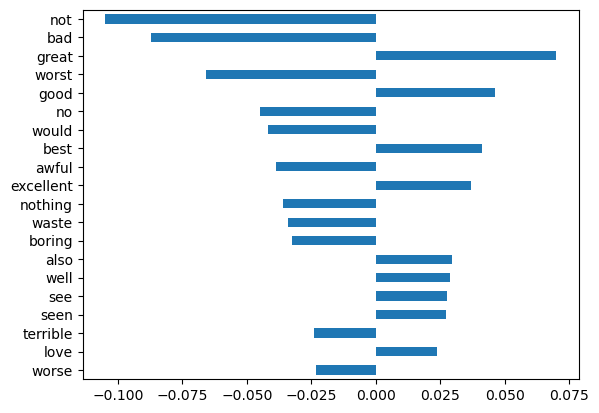

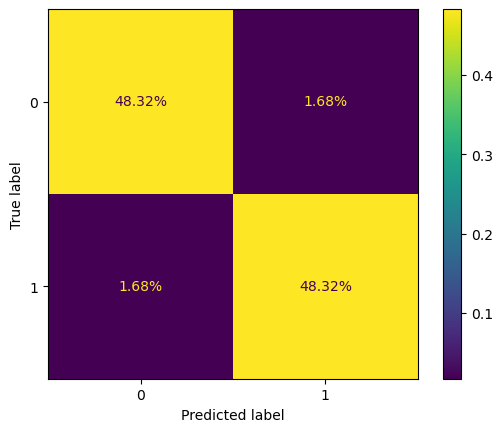

In [41]:
disp, report, feature_effects = postprocess.results_analysis(model, df_train["review"],
                                                       df_train["sentiment"])
display(report)

## Testing

,0,1,accuracy,macro avg,weighted avg
precision,0.881878,0.889967,0.88588,0.885922,0.885922
recall,0.891120,0.880640,0.88588,0.885880,0.885880
f1-score,0.886475,0.885279,0.88588,0.885877,0.885877
support,12500.000000,12500.000000,0.88588,25000.000000,25000.000000


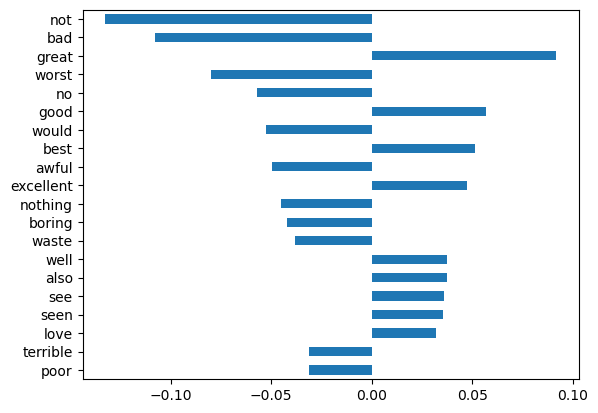

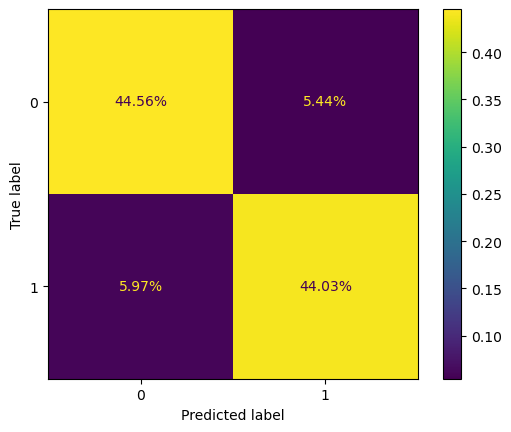

In [42]:
df_test = data.load_clean_data("./input/testData.tsv", "./input/testDataClean.tsv")


disp, report, feature_effects = postprocessing.results_analysis(model, df_test["review"],
                                                       df_test["sentiment"])
display(report)

## 

# To do next:
* Test the effects of stemming and lemmatization
* Look at the stop words and maybe remove some of them or add other words.
* Use MLFlow to manage the sklearn model saving and loading
* Use a deep learning end-to-end approach using:
  * an MLP via the sklearn implementation.
  * a recurrent neural network architecture (BRNN, GRU, LSTM, ...).
  * a transformer.

In [62]:
import re
#re.sub(r"(.)\1{3,}", r"\1\1", "aaaa bbb")
re_c = re.compile(r"(.)\1{1,}")
re_c.sub(r"\1","aaa bb")

'a b'